Word-level language model
* based on words, given clean, and no typos
* can use pretrained word embeddings (Word2Vec, GloVe)

Character-level Language model
* splitting text to characters - giving integer to every single cahracter
* useful when text datasets contain alot of out-of-vocab/infrequent words, e.g. colour names (aquatone, fuchsia) 
* text strings are short, bounded-length strings - theres a limit on length
* can have more variety - not limited to predefined dictionary
* can take a long time to train - small data and small string length to minimize

In [1]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Reshape

import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("colors.csv")
names = data["name"]
data.head()

,name,red,green,blue
0,18th Century Green,165,147,68
1,1975 Earth Red,123,70,59
2,1989 Miami Hotline,221,51,102
3,20000 Leagues Under the Sea,25,25,112
4,3AM in Shibuya,34,85,119


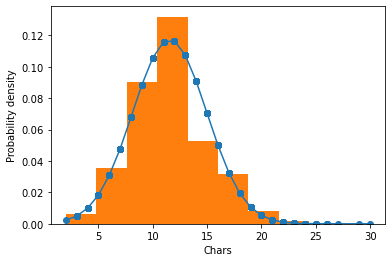

In [7]:
h = sorted(names.str.len().values) #gets length and values
import numpy as np
import scipy.stats as stats
import pylab as plt

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
plt.plot(h,fit,'-o')
plt.hist(h, density=True)      #use this to draw histogram of your data
plt.xlabel('Chars')
plt.ylabel('Probability density')
plt.show()

In [9]:
# keras tokenization to reduce number of characters >25 to 25
# less than 25 characters are padded with 0
# each character (25) is a feature/column
# each row - has associated number of those characters 
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
print(padded_names.shape)

(18606, 25)


In [17]:
# one hot encode for easier processing 
# view character integer mapping, each characters associated int
print(t.word_index)

{'e': 1, 'a': 2, ' ': 3, 'r': 4, 'i': 5, 'l': 6, 'n': 7, 'o': 8, 's': 9, 't': 10, 'c': 11, 'u': 12, 'd': 13, 'g': 14, 'p': 15, 'h': 16, 'b': 17, 'm': 18, 'y': 19, 'w': 20, 'k': 21, 'f': 22, 'v': 23, 'z': 24, 'j': 25, 'q': 26, 'x': 27, "'": 28, '-': 29, 'ō': 30, 'è': 31, 'é': 32, 'ā': 33, 'á': 34, 'ó': 35, 'ū': 36, '0': 37, '8': 38, '.': 39, 'ē': 40, 'ī': 41, 'ǎ': 42, '!': 43, 'í': 44, '&': 45, 'ǜ': 46, '9': 47, '2': 48, 'à': 49, 'ǐ': 50, '’': 51, '6': 52, 'ú': 53, '1': 54, '3': 55, 'â': 56, '4': 57, 'ǔ': 58, 'ì': 59, '7': 60, '5': 61, 'ê': 62, 'ö': 63, 'ł': 64, 'š': 65, 'ü': 66, '₂': 67, 'ò': 68, 'ñ': 69, 'ě': 70, 'ń': 71, 'ä': 72, 'œ': 73, 'ß': 74, '%': 75, 'ı': 76, 'ż': 77, '/': 78, 'î': 79, 'ë': 80, '(': 81, ')': 82, 'å': 83, '$': 84, 'я': 85, 'ő': 86, 'ğ': 87, 'ç': 88, 'ù': 89}


In [18]:
# each value will instead be represented as one hot encoding
# removes ordering of relationship which is meaningless in this case 
# e.g. integer value 2 for 'a' repped as [0,0,0,1,0] (28 digits)
from tensorflow.python.keras.utils import np_utils
one_hot_names = np_utils.to_categorical(padded_names)

In [20]:
# has the shape (18606, 25, 90), which stands for: 
# # of training samples, max sequence length, # of unique tokens).
one_hot_names.shape

(18606, 25, 90)

In [21]:
# normalize RGB values from df columns and turns to numpy array
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(data["red"]), norm(data["green"]), norm(data["blue"])])

In [22]:
# BUILDING THE MODEL 
# 1. Feed forward - normal input to output
# 2. Recurrent - remembers information LSTM in this case 
# in model - recurrent then feedfoward

In [23]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, 90)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [40]:
# fit model, more epochs will be better, with smaller batch size 
history = model.fit(one_hot_names, normalized_values,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
466/466 [==============================] - 56s 121ms/step - loss: 0.0539 - acc: 0.6390 - val_loss: 0.0578 - val_acc: 0.5913
Epoch 2/10
466/466 [==============================] - 59s 127ms/step - loss: 0.0505 - acc: 0.6437 - val_loss: 0.0564 - val_acc: 0.6083
Epoch 3/10
466/466 [==============================] - 60s 128ms/step - loss: 0.0485 - acc: 0.6539 - val_loss: 0.0573 - val_acc: 0.5656
Epoch 4/10
466/466 [==============================] - 59s 126ms/step - loss: 0.0463 - acc: 0.6553 - val_loss: 0.0579 - val_acc: 0.6008
Epoch 5/10
466/466 [==============================] - 57s 123ms/step - loss: 0.0437 - acc: 0.6590 - val_loss: 0.0568 - val_acc: 0.5798
Epoch 6/10
466/466 [==============================] - 57s 123ms/step - loss: 0.0413 - acc: 0.6650 - val_loss: 0.0572 - val_acc: 0.5758
Epoch 7/10
466/466 [==============================] - 59s 127ms/step - loss: 0.0387 - acc: 0.6655 - val_loss: 0.0604 - val_acc: 0.5779
Epoch 8/10
466/466 [==============================] - 6

In [41]:
# generating colours
# color name input needs to be transformed back to one-hot representation
# tokenize characters to integers - pad to 25 - one hot encode
# revert back to 0-255 for output 

# plot a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

def scale(n):
    return int(n * 255) 

def predict(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded, num_classes=90)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

leaf, R,G,B: 147 155 96


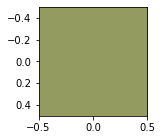

water, R,G,B: 147 184 186


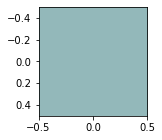

In [55]:
predict("leaf")
predict("water")